In [2]:
!pip install catboost shap pandas numpy scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.5 MB/s eta 0:00:00


In [3]:
!mkdir secom
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data -P secom/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data -P secom/

--2025-02-16 21:23:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘secom/secom.data’

secom.data              [  <=>               ]   5.14M  18.3MB/s    in 0.3s    

2025-02-16 21:23:40 (18.3 MB/s) - ‘secom/secom.data’ saved [5389983]

--2025-02-16 21:23:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘secom/secom_labels.data’

secom_labels.data       [ <=>                ]  39.69K  --.-KB/s    in 0.03s   

2025-02-16 21:23:40 (1.45 MB/s) - ‘sec

0:	learn: 0.9330951	test: 0.9197203	best: 0.9197203 (0)	total: 445ms	remaining: 7m 24s
100:	learn: 0.9753349	test: 0.9554795	best: 0.9554795 (100)	total: 21s	remaining: 3m 7s
200:	learn: 0.9894752	test: 0.9714619	best: 0.9723113 (198)	total: 32.9s	remaining: 2m 10s
300:	learn: 0.9966302	test: 0.9800235	best: 0.9800235 (299)	total: 45.5s	remaining: 1m 45s
400:	learn: 0.9993664	test: 0.9849424	best: 0.9849424 (395)	total: 58.3s	remaining: 1m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9852333136
bestIteration = 422

Shrink model to first 423 iterations.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1463
           1       0.71      0.98      0.83       104

    accuracy                           0.97      1567
   macro avg       0.86      0.98      0.91      1567
weighted avg       0.98      0.97      0.97      1567


Top 10 Most Important Parameters:
Signal_60     6.611544
Signa

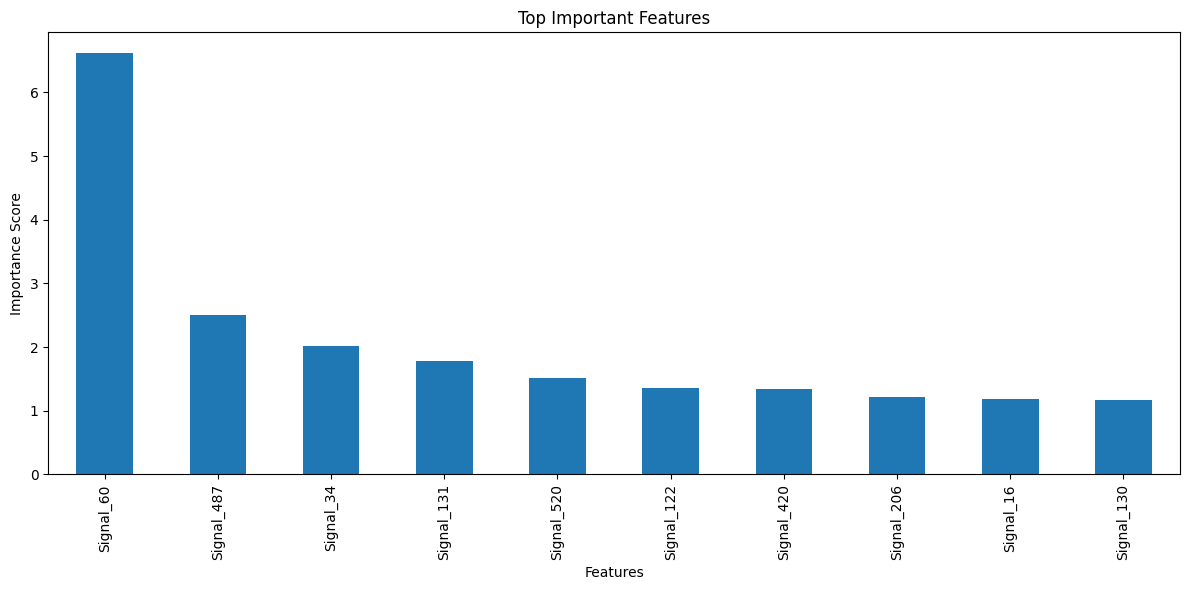

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


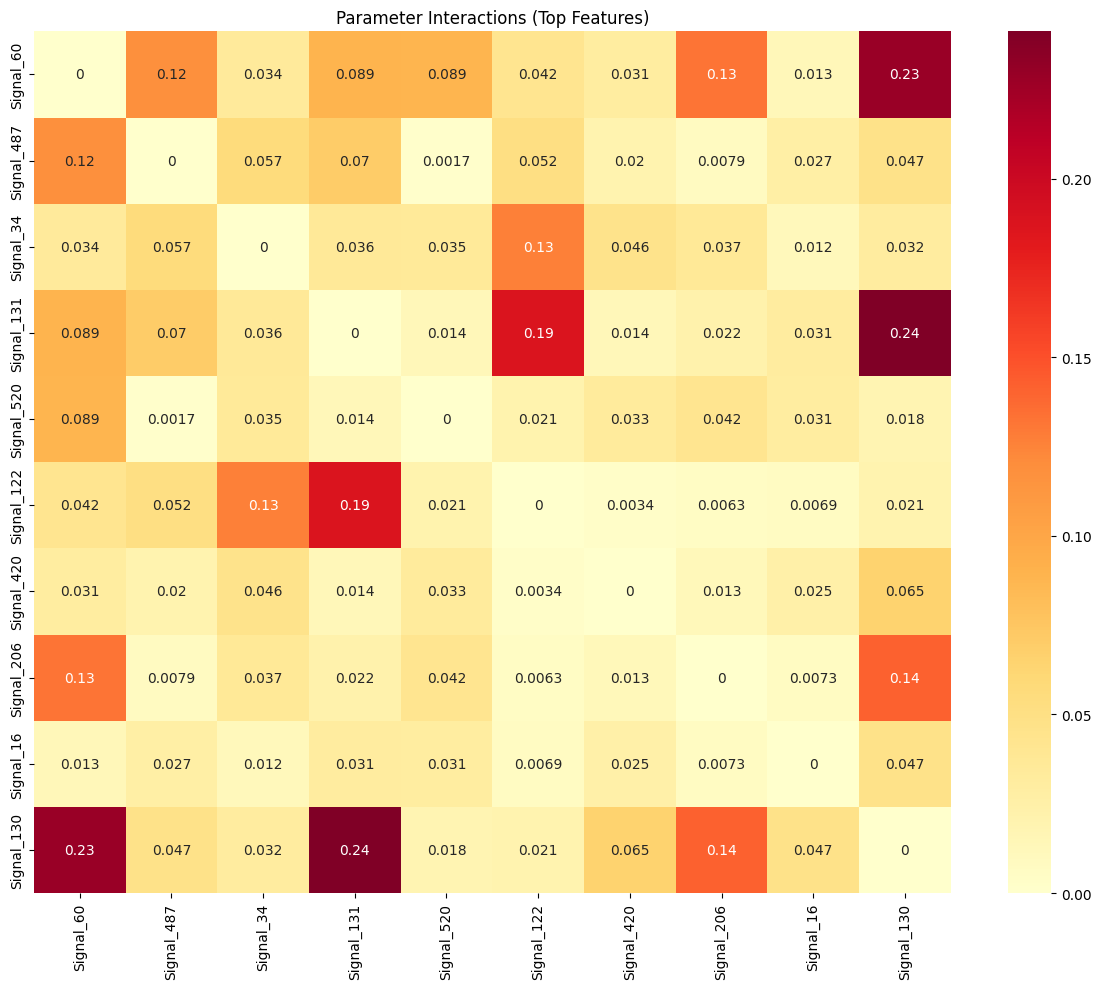

In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import seaborn as sns

class SECOMAnalyzer:
    def __init__(self, random_state=42):
        self.model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.03,
            depth=6,
            loss_function='Logloss',
            eval_metric='F1',
            class_weights={0: 1, 1: 6},
            verbose=100,
            random_state=random_state,
            task_type='CPU'
        )
        self.scaler = StandardScaler()
        self.feature_names = None
        self.shap_values = None

    def load_secom_data(self):
        data = pd.read_csv('secom/secom.data', sep=' ', header=None)
        labels = pd.read_csv('secom/secom_labels.data', sep=' ', header=None)
        data = data.replace(['NA', 'nan', 'NaN', ''], np.nan)
        data = data.fillna(data.mean())
        labels = (labels[0] + 1) // 2
        return data, labels

    def preprocess_data(self, X, y=None, training=True):
        X_scaled = self.scaler.fit_transform(X) if training else self.scaler.transform(X)

        if training:
            self.feature_names = [f'Signal_{i+1}' for i in range(X.shape[1])]
            if y is not None:
                smote = SMOTE(random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
                return X_resampled, y_resampled

        return X_scaled

    def fit(self, X, y):
        X_resampled, y_resampled = self.preprocess_data(X, y)
        X_train, X_val, y_train, y_val = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42
        )

        train_pool = Pool(X_train, y_train, feature_names=self.feature_names)
        val_pool = Pool(X_val, y_val, feature_names=self.feature_names)

        self.model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=50
        )

        explainer = shap.TreeExplainer(self.model)
        self.shap_values = explainer.shap_values(self.preprocess_data(X))

        y_pred = self.model.predict(self.preprocess_data(X))
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

        return self

    def predict_risk(self, X):
        X_preprocessed = self.preprocess_data(X, training=False)
        return self.model.predict_proba(X_preprocessed)[:, 1]

    def get_parameter_importance(self):
        importance = self.model.get_feature_importance()
        return pd.Series(importance, index=self.feature_names).sort_values(ascending=False)

    def analyze_parameter_interactions(self):
        if self.shap_values is None:
            raise ValueError("Model must be fitted first")

        n_features = len(self.feature_names)
        interaction_values = np.zeros((n_features, n_features))

        for i in range(n_features):
            for j in range(i+1, n_features):
                interaction_strength = np.abs(
                    np.corrcoef(self.shap_values[:, i], self.shap_values[:, j])[0,1]
                )
                interaction_values[i,j] = interaction_strength
                interaction_values[j,i] = interaction_strength

        return pd.DataFrame(interaction_values, index=self.feature_names, columns=self.feature_names)

    def get_critical_parameter_ranges(self, X, threshold=0.7):
        X_preprocessed = self.preprocess_data(X, training=False)
        risk_scores = self.predict_risk(X_preprocessed)
        high_risk_mask = risk_scores > threshold

        critical_ranges = {}
        for i, feature in enumerate(self.feature_names):
            if np.any(high_risk_mask):
                original_values = X[:, i]
                critical_ranges[feature] = {
                    'min': np.percentile(original_values[high_risk_mask], 5),
                    'max': np.percentile(original_values[high_risk_mask], 95),
                    'mean': np.mean(original_values[high_risk_mask]),
                    'importance': self.model.get_feature_importance()[i]
                }

        return critical_ranges

    def plot_important_features(self, top_n=10):
        importance = self.get_parameter_importance()
        plt.figure(figsize=(12, 6))
        importance.head(top_n).plot(kind='bar')
        plt.title('Top Important Features')
        plt.xlabel('Features')
        plt.ylabel('Importance Score')
        plt.tight_layout()
        plt.show()

    def plot_interaction_heatmap(self, top_n=10):
       interactions = self.analyze_parameter_interactions()
       importance = self.get_parameter_importance()
       top_features = importance.head(top_n).index

       plt.figure(figsize=(12, 10))
       sns.heatmap(
           interactions.loc[top_features, top_features],
            annot=True,
           cmap='YlOrRd'
        )
       plt.title('Parameter Interactions (Top Features)')
       plt.tight_layout()
       plt.show()

def main():
    analyzer = SECOMAnalyzer()
    X, y = analyzer.load_secom_data()
    analyzer.fit(X, y)

    importance = analyzer.get_parameter_importance()
    print("\nTop 10 Most Important Parameters:")
    print(importance.head(10))

    critical_ranges = analyzer.get_critical_parameter_ranges(X)
    print("\nCritical Parameter Ranges (Top 5 by Importance):")
    sorted_ranges = dict(sorted(critical_ranges.items(),
                              key=lambda x: x[1]['importance'],
                              reverse=True)[:5])
    for param, ranges in sorted_ranges.items():
        print(f"\n{param}:")
        print(f"Range: {ranges['min']:.3f} to {ranges['max']:.3f}")
        print(f"Mean: {ranges['mean']:.3f}")
        print(f"Importance: {ranges['importance']:.3f}")

    analyzer.plot_important_features()
    analyzer.plot_interaction_heatmap()

    return analyzer

if __name__ == "__main__":
    analyzer = main()

0:	learn: 0.9330951	test: 0.9197203	best: 0.9197203 (0)	total: 323ms	remaining: 5m 23s
100:	learn: 0.9753349	test: 0.9554795	best: 0.9554795 (100)	total: 13.7s	remaining: 2m 2s
200:	learn: 0.9894752	test: 0.9714619	best: 0.9723113 (198)	total: 27.1s	remaining: 1m 47s
300:	learn: 0.9966302	test: 0.9800235	best: 0.9800235 (299)	total: 40.3s	remaining: 1m 33s
400:	learn: 0.9993664	test: 0.9849424	best: 0.9849424 (395)	total: 53.7s	remaining: 1m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9852333136
bestIteration = 422

Shrink model to first 423 iterations.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1463
           1       0.65      0.98      0.78       104

    accuracy                           0.96      1567
   macro avg       0.82      0.97      0.88      1567
weighted avg       0.98      0.96      0.97      1567


Top 10 Most Important Parameters:
Signal_60     6.611544
Sig

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


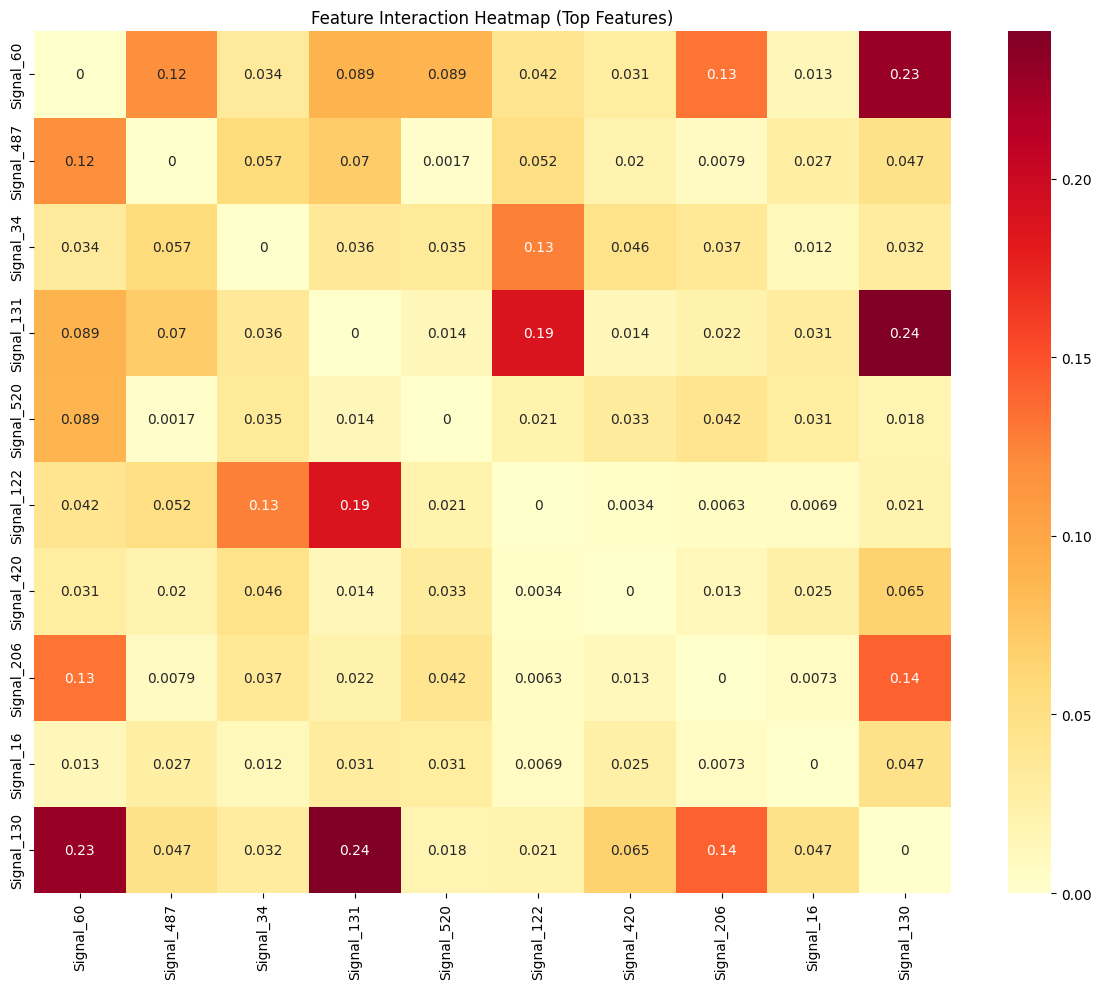


Critical Parameter Ranges (Top 5 by Importance):


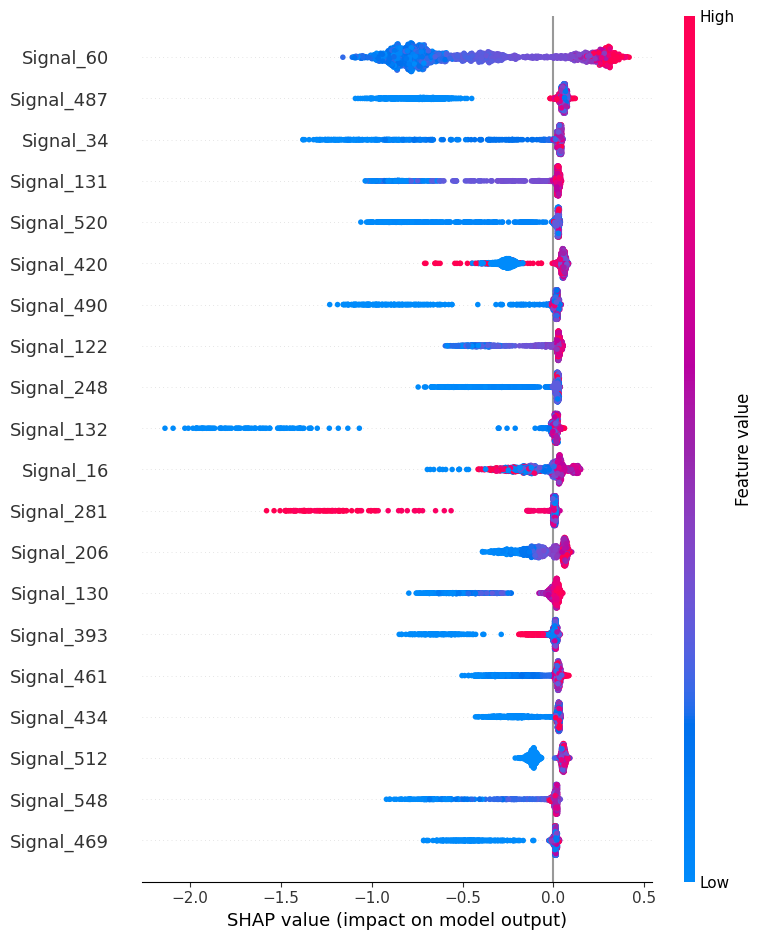

In [4]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import shap
import matplotlib.pyplot as plt
import seaborn as sns


class SECOMAnalyzer:
    def __init__(self, random_state=42):
        self.model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.03,
            depth=6,
            loss_function='Logloss',
            eval_metric='F1',
            class_weights={0: 1, 1: 6},
            verbose=100,
            random_state=random_state,
            task_type='CPU'
        )
        self.scaler = StandardScaler()
        self.feature_names = None
        self.shap_values = None
        self.threshold = None

    def load_secom_data(self):
        data = pd.read_csv('secom/secom.data', sep=' ', header=None)
        labels = pd.read_csv('secom/secom_labels.data', sep=' ', header=None)
        data = data.replace(['NA', 'nan', 'NaN', ''], np.nan)
        data = data.fillna(data.mean())
        labels = (labels[0] + 1) // 2
        return data, labels

    def preprocess_data(self, X, y=None, training=True):
        X_scaled = self.scaler.fit_transform(X) if training else self.scaler.transform(X)

        if training:
            self.feature_names = [f'Signal_{i+1}' for i in range(X.shape[1])]
            if y is not None:
                smote = SMOTE(random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
                return X_resampled, y_resampled

        return X_scaled

    def fit(self, X, y):
        X_resampled, y_resampled = self.preprocess_data(X, y)
        X_train, X_val, y_train, y_val = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42
        )

        train_pool = Pool(X_train, y_train, feature_names=self.feature_names)
        val_pool = Pool(X_val, y_val, feature_names=self.feature_names)

        self.model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=50
        )


        explainer = shap.TreeExplainer(self.model)
        self.shap_values = explainer.shap_values(self.preprocess_data(X))

        y_pred_proba = self.model.predict_proba(self.preprocess_data(X))[:, 1]
        self.threshold = np.percentile(y_pred_proba, 90)

        y_pred = (y_pred_proba > self.threshold).astype(int)
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

        return self

    def predict_risk(self, X):
        X_preprocessed = self.preprocess_data(X, training=False)
        return self.model.predict_proba(X_preprocessed)[:, 1]

    def get_top_risk_contributors(self, X, instance_index):
        if self.shap_values is None:
            raise ValueError("Model must be fitted first")

        X_preprocessed = self.preprocess_data(X, training=False)
        risk_scores = self.predict_risk(X_preprocessed)

        if instance_index >= len(risk_scores):
            raise IndexError("Instance index out of range")

        if risk_scores[instance_index] < self.threshold:
            print(f"Instance {instance_index} is not high risk (score={risk_scores[instance_index]:.4f}).")
            return

        shap_values_instance = self.shap_values[instance_index]
        feature_importances = pd.Series(shap_values_instance, index=self.feature_names).abs()
        top_contributors = feature_importances.sort_values(ascending=False).head(10)

        print(f"\nTop Contributing Features for Instance {instance_index} (Risk Score={risk_scores[instance_index]:.4f}):")
        print(top_contributors)

        explainer = shap.Explainer(self.model)
        shap_values_single = explainer(X_preprocessed[[instance_index]])
        shap.plots.waterfall(shap_values_single[0])

    def get_feature_interactions(self, top_n=10):
        if self.shap_values is None:
            raise ValueError("Model must be fitted first")

        n_features = len(self.feature_names)
        interaction_values = np.zeros((n_features, n_features))

        for i in range(n_features):
            for j in range(i+1, n_features):
                interaction_strength = np.abs(
                    np.corrcoef(self.shap_values[:, i], self.shap_values[:, j])[0, 1]
                )
                interaction_values[i, j] = interaction_strength
                interaction_values[j, i] = interaction_strength

        interactions_df = pd.DataFrame(interaction_values, index=self.feature_names, columns=self.feature_names)

        importance = pd.Series(self.model.get_feature_importance(), index=self.feature_names)
        top_features = importance.sort_values(ascending=False).head(top_n).index

        plt.figure(figsize=(12, 10))
        sns.heatmap(interactions_df.loc[top_features, top_features], annot=True, cmap='YlOrRd')
        plt.title('Feature Interaction Heatmap (Top Features)')
        plt.tight_layout()
        plt.show()

    def get_critical_parameter_ranges(self, X):
        X_preprocessed = self.preprocess_data(X, training=False)
        risk_scores = self.predict_risk(X_preprocessed)
        high_risk_mask = risk_scores > self.threshold

        critical_ranges = {}
        for i, feature in enumerate(self.feature_names):
            if np.any(high_risk_mask):
                original_values = X[:, i]
                critical_ranges[feature] = {
                    'min': np.percentile(original_values[high_risk_mask], 5),
                    'max': np.percentile(original_values[high_risk_mask], 95),
                    'mean': np.mean(original_values[high_risk_mask]),
                    'importance': self.model.get_feature_importance()[i]
                }

        return critical_ranges

    def plot_shap_summary(self, X):
        X_preprocessed = self.preprocess_data(X, training=False)
        explainer = shap.Explainer(self.model)
        shap_values = explainer(X_preprocessed)
        shap.summary_plot(shap_values, X_preprocessed, feature_names=self.feature_names)

def main():
    analyzer = SECOMAnalyzer()
    X, y = analyzer.load_secom_data()
    analyzer.fit(X, y)

    importance = pd.Series(analyzer.model.get_feature_importance(), index=analyzer.feature_names)
    print("\nTop 10 Most Important Parameters:")
    print(importance.sort_values(ascending=False).head(10))

    high_risk_instances = np.where(analyzer.predict_risk(X) > analyzer.threshold)[0]
    if len(high_risk_instances) > 0:
        sample_instance = high_risk_instances[0]
        analyzer.get_top_risk_contributors(X, sample_instance)
    else:
        print("\nNo high-risk instances detected based on dynamic threshold.")

    analyzer.get_feature_interactions()
    critical_ranges = analyzer.get_critical_parameter_ranges(X)

    print("\nCritical Parameter Ranges (Top 5 by Importance):")
    sorted_ranges = dict(sorted(critical_ranges.items(), key=lambda x: x[1]['importance'], reverse=True)[:5])
    for param, ranges in sorted_ranges.items():
        print(f"\n{param}:")
        print(f"Range: {ranges['min']:.3f} to {ranges['max']:.3f}")
        print(f"Mean: {ranges['mean']:.3f}")
        print(f"Importance: {ranges['importance']:.3f}")

    analyzer.plot_shap_summary(X)

    return analyzer

if __name__ == "__main__":
    analyzer = main()


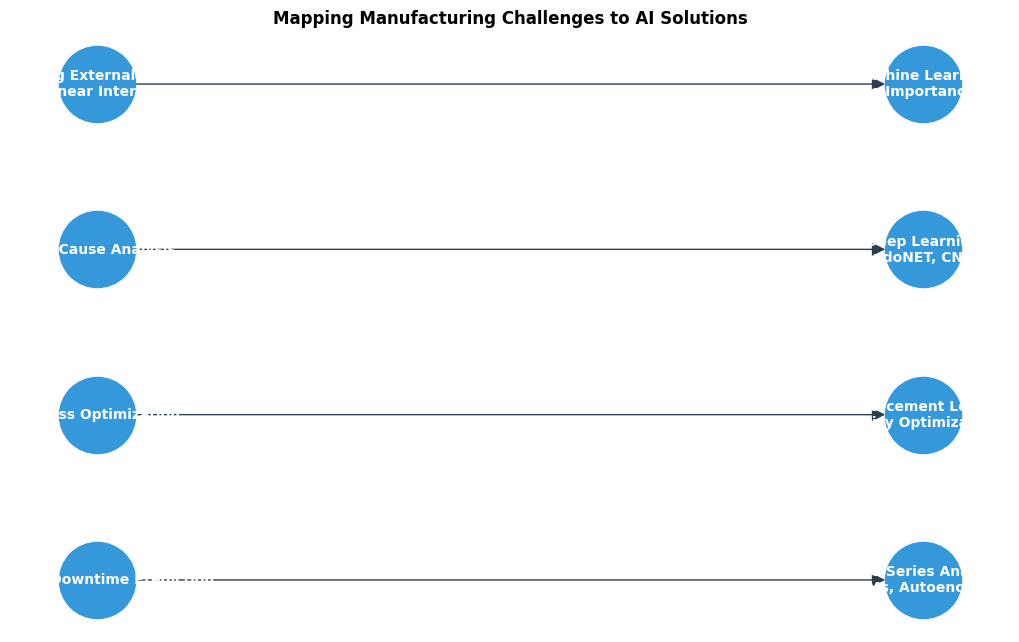

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Nodes: Problems and Solutions
problems = [
    "Handling External Factors\n& Nonlinear Interactions",
    "Root Cause Analysis",
    "Process Optimization",
    "Machine Downtime Prediction"
]

solutions = [
    "Machine Learning\n(Feature Importance, SHAP)",
    "Deep Learning\n(EndoNET, CNNs)",
    "Reinforcement Learning\n(Policy Optimization)",
    "Time-Series Analysis\n(LSTMs, Autoencoders)"
]

# Add nodes to the graph
for p in problems:
    G.add_node(p, type="problem")
for s in solutions:
    G.add_node(s, type="solution")

# Define edges connecting problems to solutions
edges = [
    (problems[0], solutions[0]),  # Handling External Factors -> ML
    (problems[1], solutions[1]),  # Root Cause Analysis -> Deep Learning
    (problems[2], solutions[2]),  # Process Optimization -> RL
    (problems[3], solutions[3])   # Machine Downtime Prediction -> LSTMs
]

# Add edges to the graph
G.add_edges_from(edges)

# Define positions for the nodes
pos = {
    problems[0]: (-2, 1),
    problems[1]: (-2, 0),
    problems[2]: (-2, -1),
    problems[3]: (-2, -2),
    solutions[0]: (2, 1),
    solutions[1]: (2, 0),
    solutions[2]: (2, -1),
    solutions[3]: (2, -2)
}

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="#3498db", edge_color="#2c3e50",
        font_size=10, font_color="white", font_weight="bold", arrows=True, arrowstyle="-|>", arrowsize=20)

# Display the visualization
plt.title("Mapping Manufacturing Challenges to AI Solutions", fontsize=12, fontweight="bold")
plt.show()
